In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import sys
import argparse
import h5py
from scipy.stats import t as student_t
from statsmodels.stats import multitest as mt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
# IDP_df = pd.read_pickle('male_IDP_prototype.pkl')
# vars_df = pd.read_pickle('male_vars_prototype.pkl')

IDP_df = pd.read_pickle('male_IDP_ensembles_testset.pkl')
vars_df = pd.read_pickle('male_vars_ensembles_testset.pkl')

# IDP_names = np.loadtxt("IDP_names.txt", dtype=str, delimiter='\n')
# IDP_categories = np.loadtxt("IDP_categories.txt", dtype=str, delimiter='\n')


with open('IDP_names.txt') as f:
    IDP_names = f.readlines()
    IDP_names = [l.strip('\n\r') for l in IDP_names]
    IDP_names = np.array(IDP_names)
# vars_categories = np.loadtxt("vars_categories.txt", dtype=str, delimiter='\n')
with open('IDP_categories.txt') as f:
    IDP_categories = f.readlines()
    IDP_categories = [l.strip('\n\r') for l in IDP_categories]
    IDP_categories = np.array(IDP_categories)


with open('varsHeader.txt') as f:
    varsHeader = f.readlines()
    varsHeader = [l.strip('\n\r') for l in varsHeader]
    varsHeader = np.array(varsHeader)
# vars_categories = np.loadtxt("vars_categories.txt", dtype=str, delimiter='\n')
with open('vars_categories.txt') as f:
    vars_categories = f.readlines()
    vars_categories = [l.strip('\n\r') for l in vars_categories]
    vars_categories = np.array(vars_categories)

In [4]:
vars_df.head()

,modality,bonf,fdr,dataframe
0,NaiveFull,5.508287,3.933050,idx ...
1,LinearRegressionFull,5.508287,4.485197,idx ...
2,ElasticNetFull,5.508287,4.765178,idx ...
3,Cluster1,5.508287,4.108133,idx ...
4,Cluster2,5.508287,4.502409,idx ...


In [5]:
vars_df.iloc[0].dataframe.head()

,idx,names,Categories,pearson_r,t_test_statistic,p_values_corrected,p_values,abs_pearson_r,log_p_values,log_p_values_corrected
0,0,Ethnic background (0.0),Ethnic Background,0.016286,0.759648,1.000000,0.447547,0.016286,0.349161,-0.000000
1,1,Ethnic background (1.0),Ethnic Background,-0.005304,0.104620,1.000000,0.916732,0.005304,0.037758,-0.000000
2,2,Ethnic background (2.0),Ethnic Background,0.059198,1.497888,0.945546,0.134657,0.059198,0.870772,0.024317
3,3,Genotype measurement batch (0.0),Genetic Markers,-0.024794,1.145993,1.000000,0.251927,0.024794,0.598726,-0.000000
4,4,Heterozygosity (0.0),Genetic Markers,-0.011541,0.533297,1.000000,0.593884,0.011541,0.226299,-0.000000


In [6]:
vars_over_bThr_list = []

for idx in range(len(vars_df)):
    df = vars_df.iloc[idx].dataframe
    bThr = vars_df.iloc[idx].bonf
    vars_over_bThr = df[df.log_p_values>=bThr].sort_values('log_p_values', ascending=False).names.to_list()
    for var in vars_over_bThr:
        vars_over_bThr_list.append(var)

In [7]:
print("Number of unique vars across all modalities: ", len(set(vars_over_bThr_list)))

Number of unique vars across all modalities:  36


In [8]:
unique_vars_over_bTHr = list(set(vars_over_bThr_list))

In [9]:
unique_vars_over_bThr_categories = []

for var in unique_vars_over_bTHr:
    idx = list(varsHeader).index(var)
    category = vars_categories[idx]
    unique_vars_over_bThr_categories.append(category)

In [10]:
sorted(unique_vars_over_bTHr)

['Alcohol (2.0)',
 'Alcohol intake frequency. (0.0)',
 'Alcohol intake frequency. (2.0)',
 'Arms BMC (bone mineral content) (2.0)',
 'Arms BMD (bone mineral density) (2.0)',
 'Cereal intake (2.0)',
 'Diabetes diagnosed by doctor (2.0)',
 'Diagnoses - ICD10 (S761 - S76.1 Injury of quadriceps muscle and tendon)',
 'Diagnoses - ICD10 (W014 - W01.4 Street and highway)',
 'Diagnoses - main ICD10 (S761 - S76.1 Injury of quadriceps muscle and tendon)',
 'Diagnoses - secondary ICD10 (E119 - E11.9 Without complications)',
 'External causes - ICD10 (W014 - W01.4 Street and highway)',
 'Femur total BMD (bone mineral density) (right) (2.0)',
 'Femur wards BMD (bone mineral density) (left) (2.0)',
 'Femur wards BMD (bone mineral density) (right) (2.0)',
 'Femur wards BMD (bone mineral density) T-score (left) (2.0)',
 'Femur wards BMD (bone mineral density) T-score (right) (2.0)',
 'Frequency of drinking alcohol (0.0)',
 'Hand grip strength (left) (2.0)',
 'Hand grip strength (right) (2.0)',
 'Head 

In [11]:
modalities = []
pearson_rs_list = []
for var in unique_vars_over_bTHr:
    modalities_with_var = []
    pearsonRs_with_var = []
    for idx in range(len(vars_df)):
        df = vars_df.iloc[idx].dataframe
        modality = vars_df.iloc[idx].modality
        bThr = vars_df.iloc[idx].bonf
        df = df[df.log_p_values>=bThr].sort_values('log_p_values', ascending=False)
        vars_over_bThr = df.names.to_list()
        pearson_r_over_bThr = df.pearson_r.to_list()
        if var in vars_over_bThr:
            modalities_with_var.append(modality)
            pearsonRs_with_var.append(pearson_r_over_bThr[vars_over_bThr.index(var)])
    modalities.append(modalities_with_var)
    pearson_rs_list.append(pearsonRs_with_var)

In [12]:
len(modalities)

36

In [13]:
df_vars_over_bThr = pd.DataFrame.from_dict({
    'names': unique_vars_over_bTHr,
    'Categories': unique_vars_over_bThr_categories,
    'modalities': modalities,
    'pearson_r': pearson_rs_list
})

In [14]:
df_vars_over_bThr.head()

,names,Categories,modalities,pearson_r
0,Femur wards BMD (bone mineral density) T-score...,Skeletal Measurements,[Cluster7],[-0.10936253203717718]
1,Femur wards BMD (bone mineral density) (left) ...,Skeletal Measurements,[Cluster7],[-0.10884997079693164]
2,External causes - ICD10 (W014 - W01.4 Street a...,Medical History,"[LinearRegressionFull, ElasticNetFull, Cluster...","[-0.102587084213179, -0.10622443370264631, -0...."
3,Femur wards BMD (bone mineral density) (right)...,Skeletal Measurements,[Cluster7],[-0.11353916838070763]
4,Arms BMC (bone mineral content) (2.0),Skeletal Measurements,[Cluster7],[-0.11241020930431879]


In [15]:
set(df_vars_over_bThr.Categories.to_list())

{'Alcohol',
 'Blood Assays',
 'Diet',
 'Medical History',
 'Physical Measurements',
 'Skeletal Measurements',
 'Tobacco'}

In [16]:
for cat in sorted(list(set(df_vars_over_bThr.Categories.to_list()))):
    print("Category: {}".format(cat))
    print('------------------------------------------------')
    names = df_vars_over_bThr[df_vars_over_bThr.Categories == cat].names.to_list()
    for name in sorted(names):
        print('Var: {}'.format(name))
        mods = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].modalities.to_list()
        prs = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].pearson_r.to_list()
        print('   Modalities:')
        for i, mod in enumerate(mods[0]):
            print('   -> {} ({:.3f})'.format(mod, prs[0][i]))
        
    print('\n')

Category: Alcohol
------------------------------------------------
Var: Alcohol intake frequency. (0.0)
   Modalities:
   -> Cluster1 (0.105)
   -> Cluster8 (0.103)
Var: Alcohol intake frequency. (2.0)
   Modalities:
   -> Cluster1 (0.108)
   -> Cluster2 (0.104)
   -> Cluster3 (0.102)
   -> Cluster8 (0.114)
   -> Cluster9 (0.109)
   -> MLP (0.105)
Var: Frequency of drinking alcohol (0.0)
   Modalities:
   -> Cluster1 (0.128)
   -> Cluster2 (0.123)
   -> Cluster3 (0.126)
   -> Cluster8 (0.137)
   -> Cluster9 (0.132)


Category: Blood Assays
------------------------------------------------
Var: IGF-1 (0.0)
   Modalities:
   -> NaiveFull (-0.112)
   -> LinearRegressionFull (-0.110)
   -> ElasticNetFull (-0.112)
   -> Cluster3 (-0.125)
   -> Cluster9 (-0.119)
   -> Cluster10 (-0.109)
   -> Cluster11 (-0.111)
   -> RENT (-0.108)
   -> MLP (-0.118)


Category: Diet
------------------------------------------------
Var: Alcohol (2.0)
   Modalities:
   -> Cluster3 (0.214)
   -> Cluster9 (0.207)

In [17]:
sorted(prs[0], reverse=True)

[0.11185858603797538, 0.10840010351258267, 0.10234504983631046]

In [18]:
for cat in sorted(list(set(df_vars_over_bThr.Categories.to_list()))):
    print("Category: {}".format(cat))
    print('------------------------------------------------')
    names = df_vars_over_bThr[df_vars_over_bThr.Categories == cat].names.to_list()
    for name in sorted(names):
        print('Var: {}'.format(name))
        mods = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].modalities.to_list()
        prs = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].pearson_r.to_list()
        print('   Modalities:')
        
        prs_abs = np.abs(prs).tolist()
        _, mods = zip(*sorted(zip(prs_abs[0], mods[0]), reverse=True))
        _, prs = zip(*sorted(zip(prs_abs[0], prs[0]), reverse=True))
        
        for i, mod in enumerate(mods):
            print('   -> {} ({:.3f})'.format(mod, prs[i]))
        
    print('\n')

Category: Alcohol
------------------------------------------------
Var: Alcohol intake frequency. (0.0)
   Modalities:
   -> Cluster1 (0.105)
   -> Cluster8 (0.103)
Var: Alcohol intake frequency. (2.0)
   Modalities:
   -> Cluster8 (0.114)
   -> Cluster9 (0.109)
   -> Cluster1 (0.108)
   -> MLP (0.105)
   -> Cluster2 (0.104)
   -> Cluster3 (0.102)
Var: Frequency of drinking alcohol (0.0)
   Modalities:
   -> Cluster8 (0.137)
   -> Cluster9 (0.132)
   -> Cluster1 (0.128)
   -> Cluster3 (0.126)
   -> Cluster2 (0.123)


Category: Blood Assays
------------------------------------------------
Var: IGF-1 (0.0)
   Modalities:
   -> Cluster3 (-0.125)
   -> Cluster9 (-0.119)
   -> MLP (-0.118)
   -> NaiveFull (-0.112)
   -> ElasticNetFull (-0.112)
   -> Cluster11 (-0.111)
   -> LinearRegressionFull (-0.110)
   -> Cluster10 (-0.109)
   -> RENT (-0.108)


Category: Diet
------------------------------------------------
Var: Alcohol (2.0)
   Modalities:
   -> Cluster3 (0.214)
   -> Cluster9 (0.207)

In [19]:
variance_threshold = 0.1

for cat in sorted(list(set(df_vars_over_bThr.Categories.to_list()))):
    print("Category: {}".format(cat))
    print('------------------------------------------------')
    names = df_vars_over_bThr[df_vars_over_bThr.Categories == cat].names.to_list()
    for name in sorted(names):
        
        mods = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].modalities.to_list()
        prs = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].pearson_r.to_list()
        
        
        prs_abs = np.abs(prs).tolist()
        _, mods = zip(*sorted(zip(prs_abs[0], mods[0]), reverse=True))
        _, prs = zip(*sorted(zip(prs_abs[0], prs[0]), reverse=True))
        
        if prs[0] >= variance_threshold:
            print('Var: {}'.format(name))
            print('   Modalities:')
            for i, mod in enumerate(mods):
                if prs[i] >= variance_threshold:
                    print('   -> {} ({:.3f})'.format(mod, prs[i]))
        
    print('\n')

Category: Alcohol
------------------------------------------------
Var: Alcohol intake frequency. (0.0)
   Modalities:
   -> Cluster1 (0.105)
   -> Cluster8 (0.103)
Var: Alcohol intake frequency. (2.0)
   Modalities:
   -> Cluster8 (0.114)
   -> Cluster9 (0.109)
   -> Cluster1 (0.108)
   -> MLP (0.105)
   -> Cluster2 (0.104)
   -> Cluster3 (0.102)
Var: Frequency of drinking alcohol (0.0)
   Modalities:
   -> Cluster8 (0.137)
   -> Cluster9 (0.132)
   -> Cluster1 (0.128)
   -> Cluster3 (0.126)
   -> Cluster2 (0.123)


Category: Blood Assays
------------------------------------------------


Category: Diet
------------------------------------------------
Var: Alcohol (2.0)
   Modalities:
   -> Cluster3 (0.214)
   -> Cluster9 (0.207)


Category: Medical History
------------------------------------------------
Var: Diabetes diagnosed by doctor (2.0)
   Modalities:
   -> NaiveFull (0.104)
   -> MLP (0.101)
Var: Diagnoses - secondary ICD10 (E119 - E11.9 Without complications)
   Modalities:


In [20]:
mods

('Cluster8', 'Cluster1', 'Cluster2')

In [21]:
counter = 0
for cat in sorted(list(set(df_vars_over_bThr.Categories.to_list()))):
    print("Category: {}".format(cat))
    print('------------------------------------------------')
    names = df_vars_over_bThr[df_vars_over_bThr.Categories == cat].names.to_list()
    for name in sorted(names):
        mods = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].modalities.to_list()[0]
        if 'ElasticNetFull' in mods or 'ElasticNetFull' in mods or 'ElasticNetFull' in mods:
            print('Var: {}'.format(name))
            counter += 1
        else:
            pass
    print('\n')
    
print("There are {} vars independent from the conventional modalities".format(counter))

Category: Alcohol
------------------------------------------------


Category: Blood Assays
------------------------------------------------
Var: IGF-1 (0.0)


Category: Diet
------------------------------------------------


Category: Medical History
------------------------------------------------
Var: External causes - ICD10 (W014 - W01.4 Street and highway)


Category: Physical Measurements
------------------------------------------------


Category: Skeletal Measurements
------------------------------------------------


Category: Tobacco
------------------------------------------------


There are 2 vars independent from the conventional modalities


In [22]:
# IDP_df0 = pd.read_pickle('male_IDP_testB.pkl')
vars_df0 = pd.read_pickle('male_vars_testB.pkl')

In [23]:
vars0_over_bThr_list = []

for idx in range(len(vars_df0)):
    df = vars_df0.iloc[idx].dataframe
    bThr = vars_df0.iloc[idx].bonf
    vars_over_bThr = df[df.log_p_values>=bThr].sort_values('log_p_values', ascending=False).names.to_list()
    for var in vars_over_bThr:
        vars0_over_bThr_list.append(var)

In [24]:
print("Number of unique vars across all modalities: ", len(set(vars0_over_bThr_list)))

Number of unique vars across all modalities:  42


In [25]:
unique_vars0_over_bTHr = list(set(vars0_over_bThr_list))
unique_vars0_over_bThr_categories = []

for var in unique_vars0_over_bTHr:
    idx = list(varsHeader).index(var)
    category = vars_categories[idx]
    unique_vars0_over_bThr_categories.append(category)
    
modalities0 = []
pearson_rs_list0 = []
for var in unique_vars0_over_bTHr:
    modalities_with_var = []
    pearsonRs_with_var = []
    for idx in range(len(vars_df0)):
        df = vars_df0.iloc[idx].dataframe
        modality = vars_df0.iloc[idx].modality
        bThr = vars_df0.iloc[idx].bonf
        df = df[df.log_p_values>=bThr].sort_values('log_p_values', ascending=False)
        vars_over_bThr = df.names.to_list()
        pearson_r_over_bThr = df.pearson_r.to_list()
        if var in vars_over_bThr:
            modalities_with_var.append(modality)
            pearsonRs_with_var.append(pearson_r_over_bThr[vars_over_bThr.index(var)])
    modalities0.append(modalities_with_var)
    pearson_rs_list0.append(pearsonRs_with_var)

In [26]:
df_vars0_over_bThr = pd.DataFrame.from_dict({
    'names': unique_vars0_over_bTHr,
    'Categories': unique_vars0_over_bThr_categories,
    'modalities': modalities0,
    'pearson_r': pearson_rs_list0
})

In [27]:
df_vars0_over_bThr[df_vars0_over_bThr.names=='Alcohol intake frequency. (2.0)']

,names,Categories,modalities,pearson_r
20,Alcohol intake frequency. (2.0),Alcohol,"[tbss_FA_s, tbss_L1_s, tbss_OD_s, tbss_ICVF, t...","[0.1081203879296585, 0.10909079636749124, 0.10..."


In [28]:
for cat in sorted(list(set(df_vars_over_bThr.Categories.to_list()))):
    print("Category: {}".format(cat))
    print('------------------------------------------------')
    names = df_vars_over_bThr[df_vars_over_bThr.Categories == cat].names.to_list()
    for name in sorted(names):
        print('Var: {}'.format(name))
        mods = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].modalities.to_list()
        prs = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].pearson_r.to_list()
        mods0 = df_vars0_over_bThr[(df_vars0_over_bThr.Categories == cat) & (df_vars0_over_bThr.names == name)].modalities.to_list()
        prs0 = df_vars0_over_bThr[(df_vars0_over_bThr.Categories == cat) & (df_vars0_over_bThr.names == name)].pearson_r.to_list()
        print('   Modalities:')
        
        prs_abs = np.abs(prs).tolist()
        _, mods = zip(*sorted(zip(prs_abs[0], mods[0]), reverse=True))
        _, prs = zip(*sorted(zip(prs_abs[0], prs[0]), reverse=True))
        
        for i, mod in enumerate(mods):
            print('   -> {} ({:.3f})'.format(mod, prs[i]))
        
        
        if len(mods0) == 0:
            print('======== ATTENTION! NEW VAR ! ==========')
        else:
            prs_abs0 = np.abs(prs0).tolist()
            _, mods0 = zip(*sorted(zip(prs_abs0[0], mods0[0]), reverse=True))
            _, prs0 = zip(*sorted(zip(prs_abs0[0], prs0[0]), reverse=True))
        

#         for i, mod in enumerate(mods0):
#             print('   -> {} ({:.3f})'.format(mod, prs0[i]))
            print('   -> {} ({:.3f})'.format(mods0[0], prs0[0]))
        
    print('\n')

Category: Alcohol
------------------------------------------------
Var: Alcohol intake frequency. (0.0)
   Modalities:
   -> Cluster1 (0.105)
   -> Cluster8 (0.103)
   -> tbss_MD (0.107)
Var: Alcohol intake frequency. (2.0)
   Modalities:
   -> Cluster8 (0.114)
   -> Cluster9 (0.109)
   -> Cluster1 (0.108)
   -> MLP (0.105)
   -> Cluster2 (0.104)
   -> Cluster3 (0.102)
   -> tbss_L1 (0.110)
Var: Frequency of drinking alcohol (0.0)
   Modalities:
   -> Cluster8 (0.137)
   -> Cluster9 (0.132)
   -> Cluster1 (0.128)
   -> Cluster3 (0.126)
   -> Cluster2 (0.123)
   -> tbss_FA_s (0.141)


Category: Blood Assays
------------------------------------------------
Var: IGF-1 (0.0)
   Modalities:
   -> Cluster3 (-0.125)
   -> Cluster9 (-0.119)
   -> MLP (-0.118)
   -> NaiveFull (-0.112)
   -> ElasticNetFull (-0.112)
   -> Cluster11 (-0.111)
   -> LinearRegressionFull (-0.110)
   -> Cluster10 (-0.109)
   -> RENT (-0.108)
   -> tbss_OD (-0.118)


Category: Diet
-------------------------------------

In [29]:
for cat in sorted(list(set(df_vars_over_bThr.Categories.to_list()))):
    print("Category: {}".format(cat))
    print('------------------------------------------------')
    names = df_vars_over_bThr[df_vars_over_bThr.Categories == cat].names.to_list()
    for name in sorted(names):
        print('Var: {}'.format(name))
        mods = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].modalities.to_list()
        prs = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].pearson_r.to_list()
        mods0 = df_vars0_over_bThr[(df_vars0_over_bThr.Categories == cat) & (df_vars0_over_bThr.names == name)].modalities.to_list()
        prs0 = df_vars0_over_bThr[(df_vars0_over_bThr.Categories == cat) & (df_vars0_over_bThr.names == name)].pearson_r.to_list()
        print('   Modalities:')
        
        prs_abs = np.abs(prs).tolist()
        _, mods = zip(*sorted(zip(prs_abs[0], mods[0]), reverse=True))
        _, prs = zip(*sorted(zip(prs_abs[0], prs[0]), reverse=True))
        
#         for i, mod in enumerate(mods):
#             print('   -> {} ({:.3f})'.format(mod, prs[i]))
        print('   -> {} ({:.3f})'.format(mods[0], prs[0]))
        
        
        if len(mods0) == 0:
            print('======== ATTENTION! NEW VAR ! ==========')
        else:
            prs_abs0 = np.abs(prs0).tolist()
            _, mods0 = zip(*sorted(zip(prs_abs0[0], mods0[0]), reverse=True))
            _, prs0 = zip(*sorted(zip(prs_abs0[0], prs0[0]), reverse=True))
        

#         for i, mod in enumerate(mods0):
#             print('   -> {} ({:.3f})'.format(mod, prs0[i]))
            print('   -> {} ({:.3f})'.format(mods0[0], prs0[0]))
        
    print('\n')

Category: Alcohol
------------------------------------------------
Var: Alcohol intake frequency. (0.0)
   Modalities:
   -> Cluster1 (0.105)
   -> tbss_MD (0.107)
Var: Alcohol intake frequency. (2.0)
   Modalities:
   -> Cluster8 (0.114)
   -> tbss_L1 (0.110)
Var: Frequency of drinking alcohol (0.0)
   Modalities:
   -> Cluster8 (0.137)
   -> tbss_FA_s (0.141)


Category: Blood Assays
------------------------------------------------
Var: IGF-1 (0.0)
   Modalities:
   -> Cluster3 (-0.125)
   -> tbss_OD (-0.118)


Category: Diet
------------------------------------------------
Var: Alcohol (2.0)
   Modalities:
   -> Cluster3 (0.214)
   -> tbss_OD (0.199)
Var: Cereal intake (2.0)
   Modalities:
   -> MLP (-0.104)
   -> tbss_MO (-0.105)


Category: Medical History
------------------------------------------------
Var: Diabetes diagnosed by doctor (2.0)
   Modalities:
   -> NaiveFull (0.104)
   -> vbm (0.105)
Var: Diagnoses - ICD10 (S761 - S76.1 Injury of quadriceps muscle and tendon)
   Mo

In [30]:
prs_diffs = []
higher = 0
lower = 0

for cat in sorted(list(set(df_vars_over_bThr.Categories.to_list()))):
    print("Category: {}".format(cat))
    print('------------------------------------------------')
    names = df_vars_over_bThr[df_vars_over_bThr.Categories == cat].names.to_list()
    for name in sorted(names):
        print('Var: {}'.format(name))
        mods = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].modalities.to_list()
        prs = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].pearson_r.to_list()
        mods0 = df_vars0_over_bThr[(df_vars0_over_bThr.Categories == cat) & (df_vars0_over_bThr.names == name)].modalities.to_list()
        prs0 = df_vars0_over_bThr[(df_vars0_over_bThr.Categories == cat) & (df_vars0_over_bThr.names == name)].pearson_r.to_list()
        print('   Modalities:')
        
        if len(mods)!=0 and len(mods0)!=0:
            prs_abs = np.abs(prs).tolist()
            _, mods = zip(*sorted(zip(prs_abs[0], mods[0]), reverse=True))
            _, prs = zip(*sorted(zip(prs_abs[0], prs[0]), reverse=True))
        
            prs_abs0 = np.abs(prs0).tolist()
            _, mods0 = zip(*sorted(zip(prs_abs0[0], mods0[0]), reverse=True))
            _, prs0 = zip(*sorted(zip(prs_abs0[0], prs0[0]), reverse=True))
            
            prs_diff = abs(prs[0]) - abs(prs0[0])
            
            print('Diff=', prs_diff)
            prs_diffs.append(prs_diff)
            
            if prs_diff >= 0:
                higher += 1
            else:
                lower += 1
        
#         for i, mod in enumerate(mods):
#             print('   -> {} ({:.3f})'.format(mod, prs[i]))
#         print('   -> {} ({:.3f})'.format(mods[0], prs[0]))
        
        
#         if len(mods0) == 0:
#             print('======== ATTENTION! NEW VAR ! ==========')
#         else:
#             prs_abs0 = np.abs(prs0).tolist()
#             _, mods0 = zip(*sorted(zip(prs_abs0[0], mods0[0]), reverse=True))
#             _, prs0 = zip(*sorted(zip(prs_abs0[0], prs0[0]), reverse=True))
        

# #         for i, mod in enumerate(mods0):
# #             print('   -> {} ({:.3f})'.format(mod, prs0[i]))
#             print('   -> {} ({:.3f})'.format(mods0[0], prs0[0]))
        
    print('\n')
    
print(np.mean(prs_diffs))
print(higher)
print(lower)

Category: Alcohol
------------------------------------------------
Var: Alcohol intake frequency. (0.0)
   Modalities:
Diff= -0.0018035731272274536
Var: Alcohol intake frequency. (2.0)
   Modalities:
Diff= 0.0033532024145569717
Var: Frequency of drinking alcohol (0.0)
   Modalities:
Diff= -0.004541452344415248


Category: Blood Assays
------------------------------------------------
Var: IGF-1 (0.0)
   Modalities:
Diff= 0.007327989294254558


Category: Diet
------------------------------------------------
Var: Alcohol (2.0)
   Modalities:
Diff= 0.015283928667821467
Var: Cereal intake (2.0)
   Modalities:
Diff= -0.0010166307574478867


Category: Medical History
------------------------------------------------
Var: Diabetes diagnosed by doctor (2.0)
   Modalities:
Diff= -0.0004979251078319757
Var: Diagnoses - ICD10 (S761 - S76.1 Injury of quadriceps muscle and tendon)
   Modalities:
Diff= -0.003590816998301369
Var: Diagnoses - ICD10 (W014 - W01.4 Street and highway)
   Modalities:
Diff= 

In [31]:
unique_vars_categories = list(set(vars_categories))
unique_vars_counters = []
for unique_category in unique_vars_categories:
    counter = 0
    for category in vars_categories:
        if unique_category == category:
            counter += 1
    unique_vars_counters.append(counter)
categories_of_interest = list(set(df_vars_over_bThr.Categories.to_list()))
categories_of_interest.sort()

counters_of_interest = []
for cat in categories_of_interest:
    idx = unique_vars_categories.index(cat)
    counters_of_interest.append(unique_vars_counters[idx])


In [32]:
modalities = []
counters = []


for idx in range(len(vars_df.modality)):
    
    modality = vars_df.iloc[idx].modality

    df_of_interest = vars_df.iloc[idx].dataframe
    bThr = vars_df.iloc[idx].bonf

    counter = []

    for category in categories_of_interest:
        counter.append(len(df_of_interest[(df_of_interest.Categories==category) & (df_of_interest.log_p_values>=bThr)]))
    
    modalities.append(modality)
    counters.append(counter)

In [33]:
unique_vars_categories2, unique_vars_counters2 = zip(*sorted(zip(unique_vars_categories, unique_vars_counters)))

In [34]:
counters = np.array(counters)
dct = {}
dct['modality'] = modalities
for idx, cat in enumerate(categories_of_interest):
    dct[cat] = counters[:, idx] / counters_of_interest[idx]
    
df_dct = pd.DataFrame.from_dict(dct)
df_dct.replace([np.inf, -np.inf], np.nan, inplace=True)

In [35]:
df_dct = pd.melt(df_dct, id_vars="modality", var_name="var_name", value_name="var_hits")

/Users/andreiroibu/opt/anaconda3/envs/agemapper2/lib/python3.10/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Alcohol'),
  Text(1, 0, 'Blood Assays'),
  Text(2, 0, 'Diet'),
  Text(3, 0, 'Medical History'),
  Text(4, 0, 'Physical Measurements'),
  Text(5, 0, 'Skeletal Measurements'),
  Text(6, 0, 'Tobacco')])

<Figure size 1152x691.2 with 0 Axes>

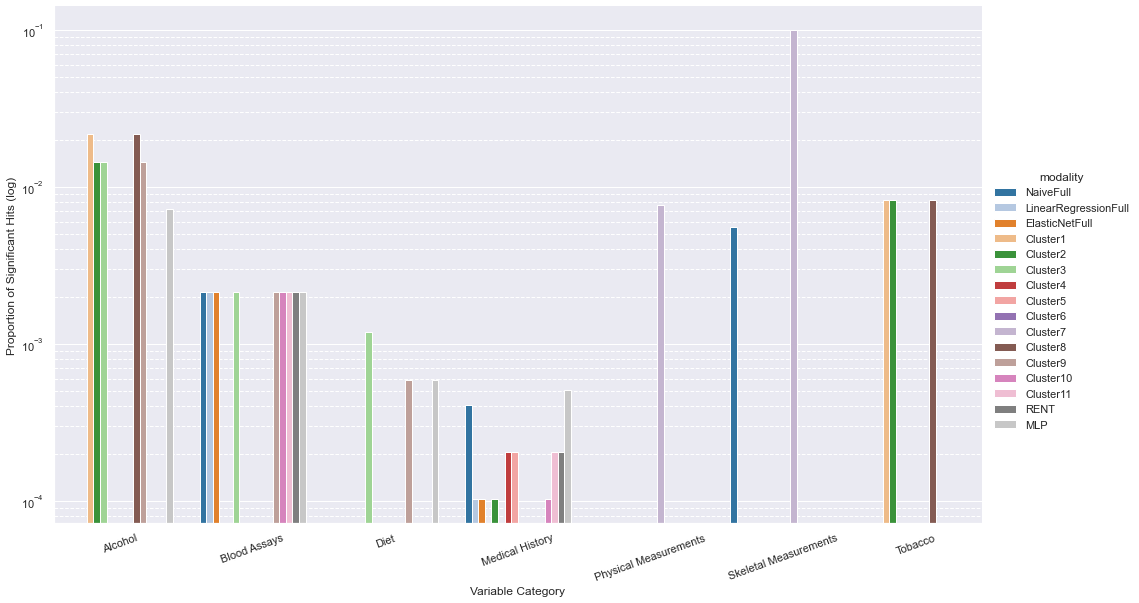

In [36]:
plt.figure(figsize=(16, 9.6))
sns.factorplot(x='var_name', y='var_hits', hue='modality', data=df_dct, kind='bar', height=8, 
               aspect=1.75, log=True, palette='tab20')
plt.xlabel('Variable Category')
plt.ylabel('Proportion of Significant Hits (log)')
plt.grid( which='minor', linestyle='--')
plt.xticks(rotation=20)

In [37]:
current_mods = vars_df.modality.values
modality_names = [
    'Naive Average', 'Linear Regression', 'ElasticNet', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6',
    'Cluster 7', 'Cluster 8', 'Cluster 9', 'Cluster 10', 'Cluster 11', 'RENT', 'MLP'
]
for idx, mod in enumerate(current_mods):
    df_dct.loc[df_dct["modality"] == mod, "modality"] = modality_names[idx]

/Users/andreiroibu/opt/anaconda3/envs/agemapper2/lib/python3.10/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


<Figure size 1152x691.2 with 0 Axes>

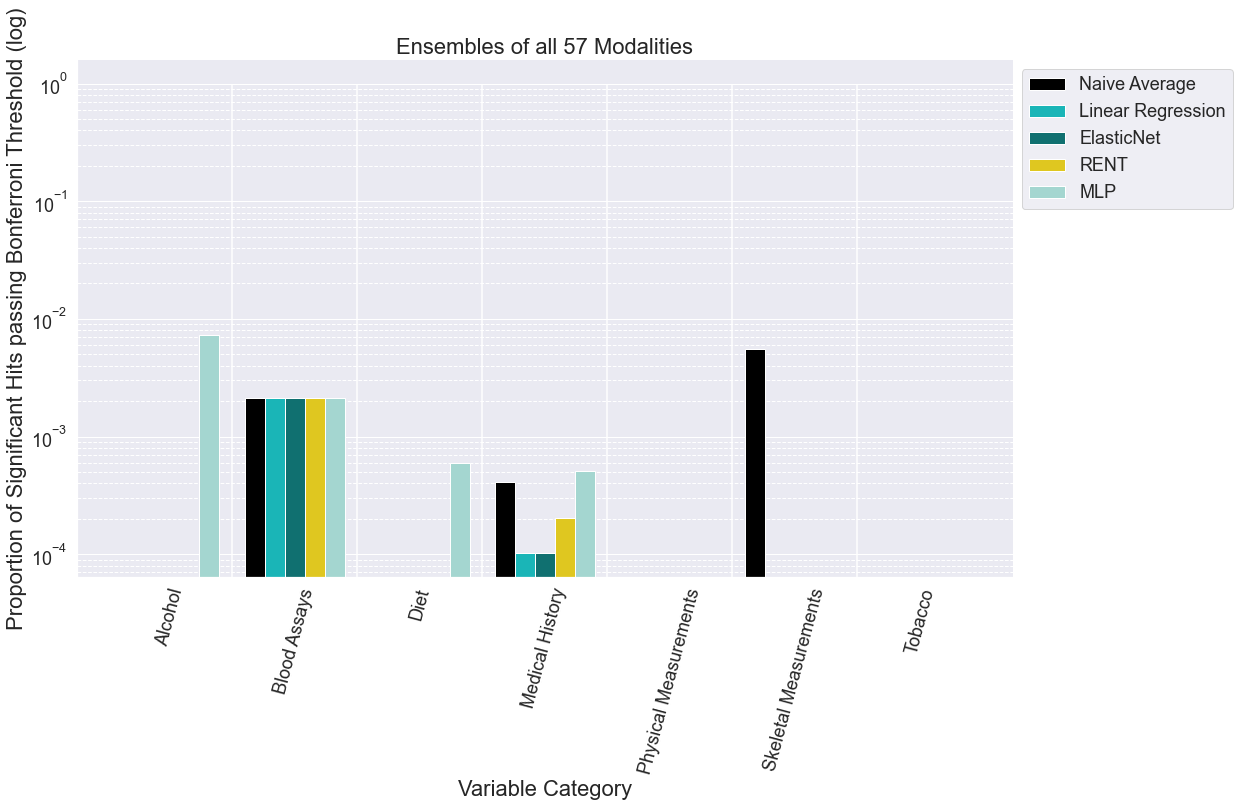

In [42]:
title_font_size=22
ticks_font_size=18
legend_font = 18
figsize=(16, 9.6)

fig = plt.figure(figsize=figsize, facecolor='white')
# fig.patch.set_facecolor('xkcd:white')
colorCycle=['#000000', '#00CED1','#008080','#ffdf00','#9cded6',
            '#8e063b','#DAACD5','#ff7f00','#8595e1','#e31a1c',
            '#fb9a99','#0a5d00','#1fc600','#000080','#1f78b4',
            '#a6cee3', '#023fa5', '#e07b91', '#50301e']

sns.factorplot(x='var_name', y='var_hits', hue='modality', 
               data=df_dct[(df_dct.modality == 'Naive Average') |
                           (df_dct.modality == 'Linear Regression') |
                           (df_dct.modality == 'ElasticNet') |
                           (df_dct.modality == 'RENT') |
                           (df_dct.modality == 'MLP') 
                          
                          ],
               kind='bar', height=8, aspect=1.75, log=True, legend_out=False,
              palette=colorCycle)


plt.xlabel('Variable Category', fontsize=title_font_size)
plt.ylabel('Proportion of Significant Hits passing Bonferroni Threshold (log)', fontsize=title_font_size)
plt.grid( which='minor', linestyle='--')
plt.xticks(rotation=75, fontsize= ticks_font_size)
plt.yticks(fontsize= ticks_font_size)
plt.title('Ensembles of all 57 Modalities', fontsize=title_font_size)
plt.vlines(x=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], ymin=0, ymax=1, color='white')
# plt.ylim([0, 0.05])
plt.legend(fontsize=legend_font, bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Male_proportion_significant_hits_ALL_modality_ensembles'+'.png', bbox_inches='tight', facecolor='white')

/Users/andreiroibu/opt/anaconda3/envs/agemapper2/lib/python3.10/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


<Figure size 1152x691.2 with 0 Axes>

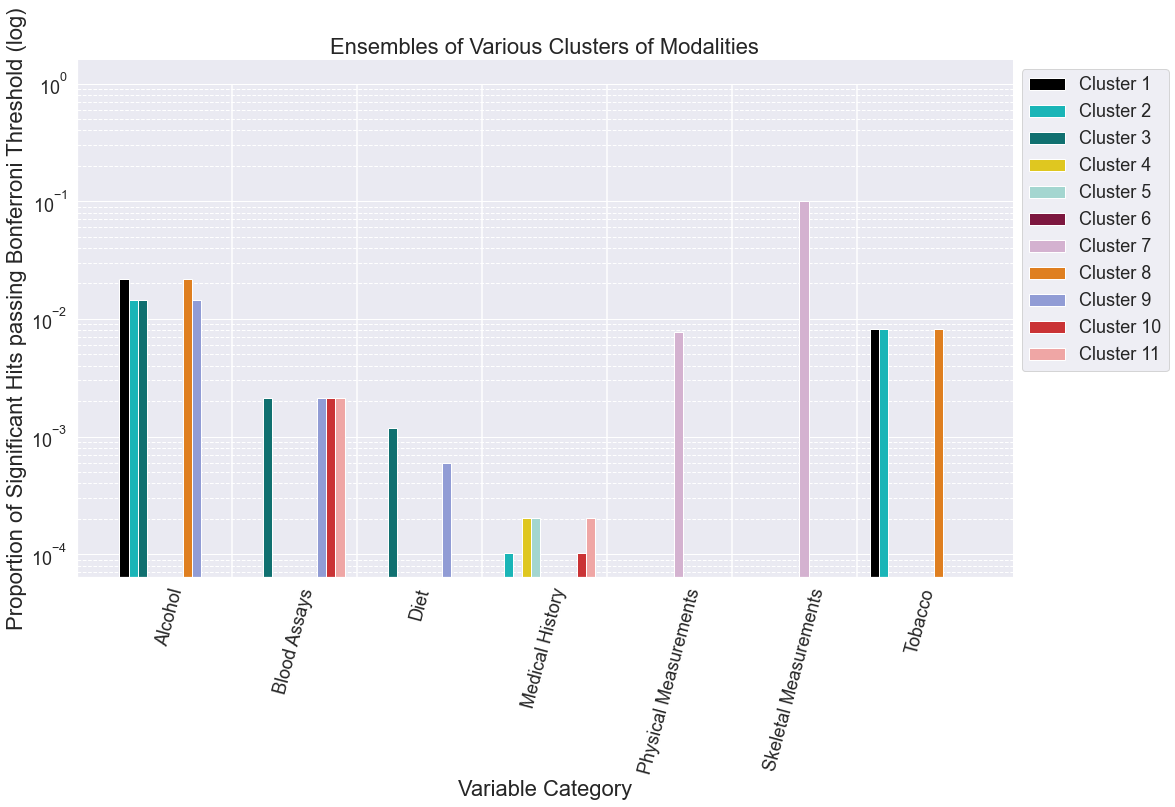

In [43]:
title_font_size=22
ticks_font_size=18
legend_font = 18
figsize=(16, 9.6)

fig = plt.figure(figsize=figsize, facecolor='white')
# fig.patch.set_facecolor('xkcd:white')
colorCycle=['#000000', '#00CED1','#008080','#ffdf00','#9cded6',
            '#8e063b','#DAACD5','#ff7f00','#8595e1','#e31a1c',
            '#fb9a99','#0a5d00','#1fc600','#000080','#1f78b4',
            '#a6cee3', '#023fa5', '#e07b91', '#50301e']

sns.factorplot(x='var_name', y='var_hits', hue='modality', 
               data=df_dct[(df_dct.modality == 'Cluster 1') |
                           (df_dct.modality == 'Cluster 2') |
                           (df_dct.modality == 'Cluster 3') |
                           (df_dct.modality == 'Cluster 4') |
                           (df_dct.modality == 'Cluster 5') |
                           (df_dct.modality == 'Cluster 6') |
                           (df_dct.modality == 'Cluster 7') |
                           (df_dct.modality == 'Cluster 8') |
                           (df_dct.modality == 'Cluster 9') |
                           (df_dct.modality == 'Cluster 10') |
                           (df_dct.modality == 'Cluster 11')
                          
                          ],
               kind='bar', height=8, aspect=1.75, log=True, legend_out=False,
              palette=colorCycle)


plt.xlabel('Variable Category', fontsize=title_font_size)
plt.ylabel('Proportion of Significant Hits passing Bonferroni Threshold (log)', fontsize=title_font_size)
plt.grid( which='minor', linestyle='--')
plt.xticks(rotation=75, fontsize= ticks_font_size)
plt.yticks(fontsize= ticks_font_size)
plt.title('Ensembles of Various Clusters of Modalities', fontsize=title_font_size)
plt.vlines(x=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], ymin=0, ymax=1, color='white')
# plt.ylim([0, 0.05])
plt.legend(fontsize=legend_font, bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Male_proportion_significant_hits_CLUSTERS_modality_ensembles'+'.png', bbox_inches='tight', facecolor='white')



In [44]:
vars_over_FDR_list = []

for idx in range(len(vars_df)):
    df = vars_df.iloc[idx].dataframe
    FDR = vars_df.iloc[idx].fdr
    vars_over_FDR = df[df.log_p_values>=FDR].sort_values('log_p_values', ascending=False).names.to_list()
    for var in vars_over_FDR:
        vars_over_FDR_list.append(var)
        
print("Number of unique vars across all modalities: ", len(set(vars_over_FDR_list)))

unique_vars_over_FDR = list(set(vars_over_FDR_list))

unique_vars_over_FDR_categories = []

for var in unique_vars_over_FDR:
    idx = list(varsHeader).index(var)
    category = vars_categories[idx]
    unique_vars_over_FDR_categories.append(category)
    
modalities = []
pearson_rs_list = []
for var in unique_vars_over_FDR:
    modalities_with_var = []
    pearsonRs_with_var = []
    for idx in range(len(vars_df)):
        df = vars_df.iloc[idx].dataframe
        modality = vars_df.iloc[idx].modality
        FDR = vars_df.iloc[idx].bonf
        df = df[df.log_p_values>=FDR].sort_values('log_p_values', ascending=False)
        vars_over_FDR = df.names.to_list()
        pearson_r_over_FDR = df.pearson_r.to_list()
        if var in vars_over_FDR:
            modalities_with_var.append(modality)
            pearsonRs_with_var.append(pearson_r_over_FDR[vars_over_FDR.index(var)])
    modalities.append(modalities_with_var)
    pearson_rs_list.append(pearsonRs_with_var)
    
print(len(modalities))

df_vars_over_FDR = pd.DataFrame.from_dict({
    'names': unique_vars_over_FDR,
    'Categories': unique_vars_over_FDR_categories,
    'modalities': modalities,
    'pearson_r': pearson_rs_list
})



unique_vars_categories = list(set(vars_categories))
unique_vars_counters = []
for unique_category in unique_vars_categories:
    counter = 0
    for category in vars_categories:
        if unique_category == category:
            counter += 1
    unique_vars_counters.append(counter)
categories_of_interest = list(set(df_vars_over_FDR.Categories.to_list()))
categories_of_interest.sort()

counters_of_interest = []
for cat in categories_of_interest:
    idx = unique_vars_categories.index(cat)
    counters_of_interest.append(unique_vars_counters[idx])

modalities = []
counters = []


for idx in range(len(vars_df.modality)):
    
    modality = vars_df.iloc[idx].modality

    df_of_interest = vars_df.iloc[idx].dataframe
    FDR = vars_df.iloc[idx].fdr

    counter = []

    for category in categories_of_interest:
        counter.append(len(df_of_interest[(df_of_interest.Categories==category) & (df_of_interest.log_p_values>=FDR)]))
    
    modalities.append(modality)
    counters.append(counter)
    
unique_vars_categories2, unique_vars_counters2 = zip(*sorted(zip(unique_vars_categories, unique_vars_counters)))

counters = np.array(counters)
dct = {}
dct['modality'] = modalities
for idx, cat in enumerate(categories_of_interest):
    dct[cat] = counters[:, idx] / counters_of_interest[idx]
    
df_dct = pd.DataFrame.from_dict(dct)
df_dct.replace([np.inf, -np.inf], np.nan, inplace=True)

df_dct = pd.melt(df_dct, id_vars="modality", var_name="var_name", value_name="var_hits")

Number of unique vars across all modalities:  103
103


In [45]:
current_mods = vars_df.modality.values
modality_names = [
    'Naive Average', 'Linear Regression', 'ElasticNet', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6',
    'Cluster 7', 'Cluster 8', 'Cluster 9', 'Cluster 10', 'Cluster 11', 'RENT', 'MLP'
]
for idx, mod in enumerate(current_mods):
    df_dct.loc[df_dct["modality"] == mod, "modality"] = modality_names[idx]

/Users/andreiroibu/opt/anaconda3/envs/agemapper2/lib/python3.10/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


<Figure size 1152x691.2 with 0 Axes>

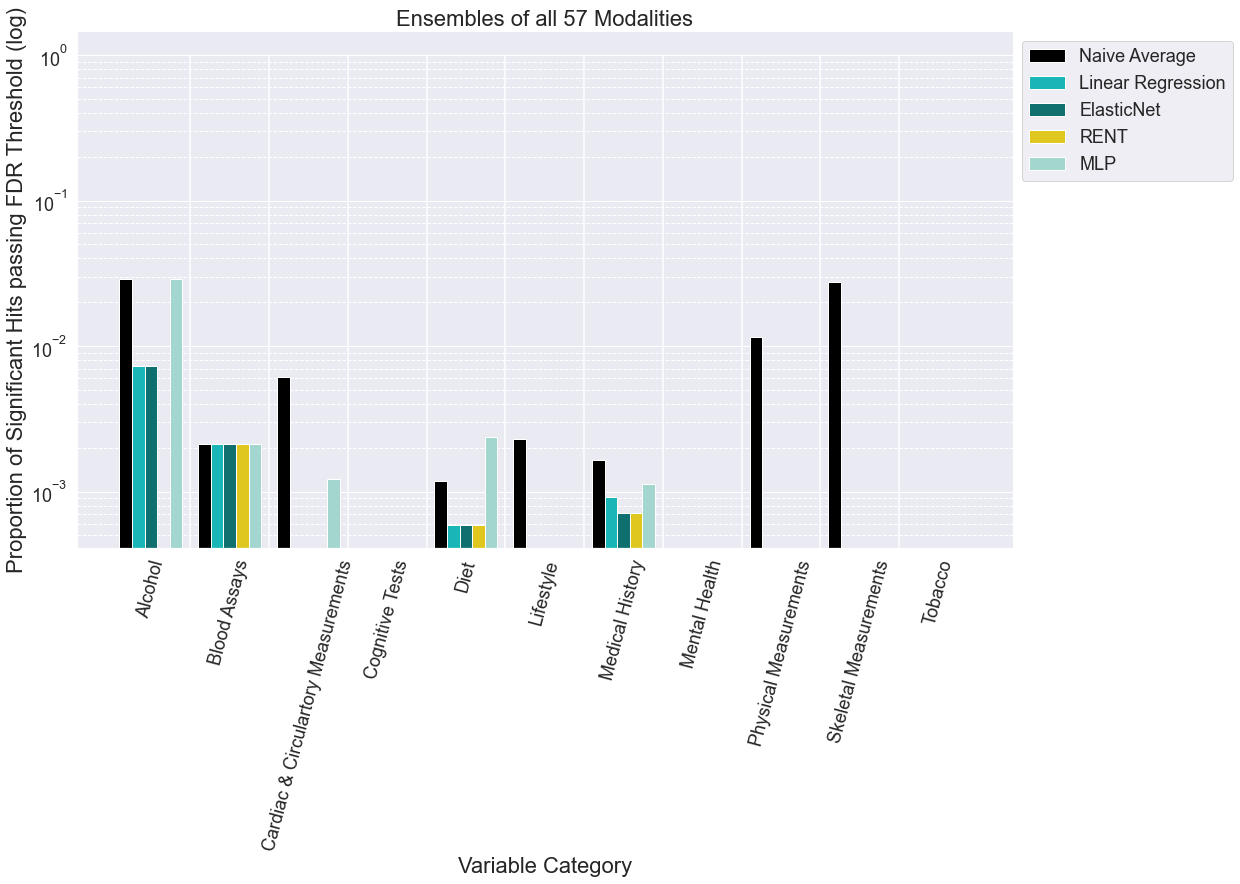

In [48]:
title_font_size=22
ticks_font_size=18
legend_font = 18
figsize=(16, 9.6)

fig = plt.figure(figsize=figsize, facecolor='white')
# fig.patch.set_facecolor('xkcd:white')
colorCycle=['#000000', '#00CED1','#008080','#ffdf00','#9cded6',
            '#8e063b','#DAACD5','#ff7f00','#8595e1','#e31a1c',
            '#fb9a99','#0a5d00','#1fc600','#000080','#1f78b4',
            '#a6cee3', '#023fa5', '#e07b91', '#50301e']

sns.factorplot(x='var_name', y='var_hits', hue='modality', 
               data=df_dct[(df_dct.modality == 'Naive Average') |
                           (df_dct.modality == 'Linear Regression') |
                           (df_dct.modality == 'ElasticNet') |
                           (df_dct.modality == 'RENT') |
                           (df_dct.modality == 'MLP') 
                          
                          ],
               kind='bar', height=8, aspect=1.75, log=True, legend_out=False,
              palette=colorCycle)


plt.xlabel('Variable Category', fontsize=title_font_size)
plt.ylabel('Proportion of Significant Hits passing FDR Threshold (log)', fontsize=title_font_size)
plt.grid( which='minor', linestyle='--')
plt.xticks(rotation=75, fontsize= ticks_font_size)
plt.yticks(fontsize= ticks_font_size)
plt.title('Ensembles of all 57 Modalities', fontsize=title_font_size)
plt.vlines(x=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5], ymin=0, ymax=1, color='white')
# plt.ylim([0, 0.05])
plt.legend(fontsize=legend_font, bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Male_FDR_proportion_significant_hits_ALL_modality_ensembles'+'.png', bbox_inches='tight', facecolor='white')




/Users/andreiroibu/opt/anaconda3/envs/agemapper2/lib/python3.10/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


<Figure size 1152x691.2 with 0 Axes>

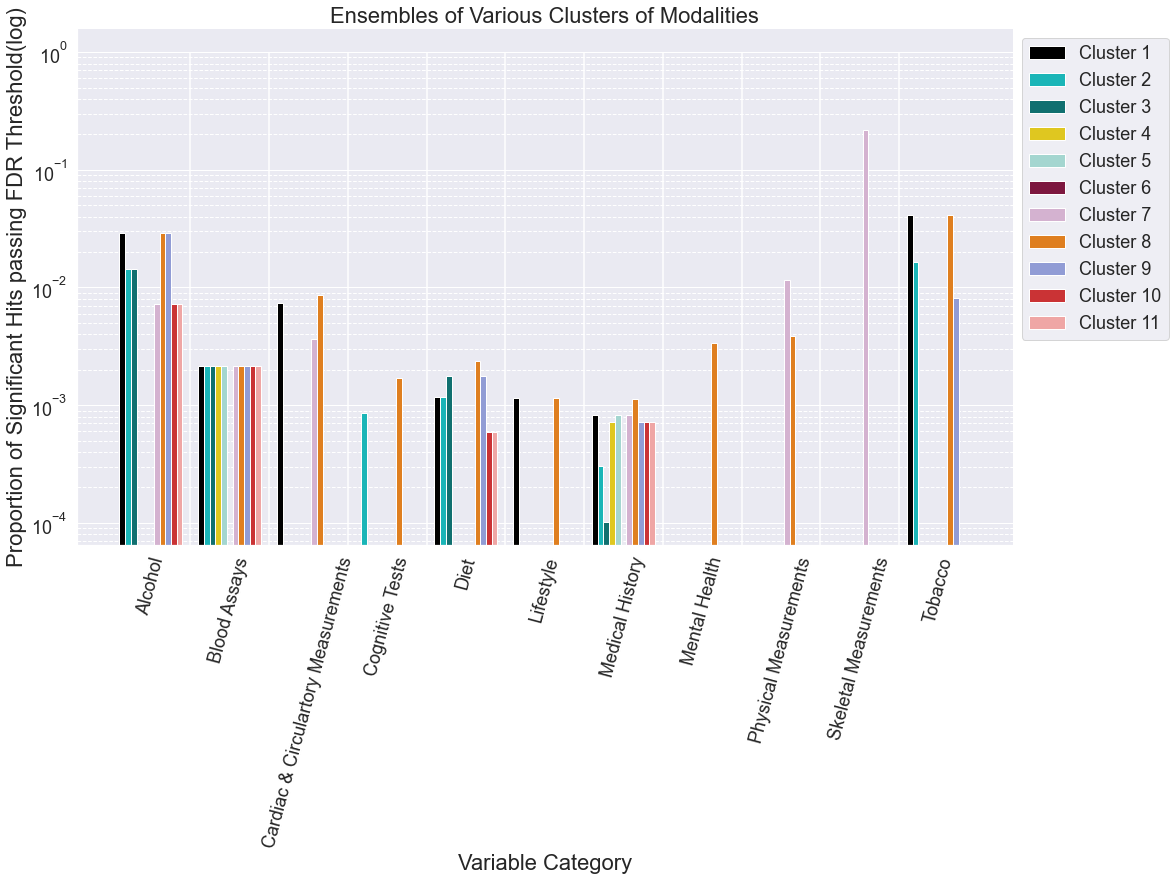

In [49]:
title_font_size=22
ticks_font_size=18
legend_font = 18
figsize=(16, 9.6)

fig = plt.figure(figsize=figsize, facecolor='white')
# fig.patch.set_facecolor('xkcd:white')
colorCycle=['#000000', '#00CED1','#008080','#ffdf00','#9cded6',
            '#8e063b','#DAACD5','#ff7f00','#8595e1','#e31a1c',
            '#fb9a99','#0a5d00','#1fc600','#000080','#1f78b4',
            '#a6cee3', '#023fa5', '#e07b91', '#50301e']

sns.factorplot(x='var_name', y='var_hits', hue='modality', 
               data=df_dct[(df_dct.modality == 'Cluster 1') |
                           (df_dct.modality == 'Cluster 2') |
                           (df_dct.modality == 'Cluster 3') |
                           (df_dct.modality == 'Cluster 4') |
                           (df_dct.modality == 'Cluster 5') |
                           (df_dct.modality == 'Cluster 6') |
                           (df_dct.modality == 'Cluster 7') |
                           (df_dct.modality == 'Cluster 8') |
                           (df_dct.modality == 'Cluster 9') |
                           (df_dct.modality == 'Cluster 10') |
                           (df_dct.modality == 'Cluster 11')
                          
                          ],
               kind='bar', height=8, aspect=1.75, log=True, legend_out=False,
              palette=colorCycle)


plt.xlabel('Variable Category', fontsize=title_font_size)
plt.ylabel('Proportion of Significant Hits passing FDR Threshold(log)', fontsize=title_font_size)
plt.grid( which='minor', linestyle='--')
plt.xticks(rotation=75, fontsize= ticks_font_size)
plt.yticks(fontsize= ticks_font_size)
plt.title('Ensembles of Various Clusters of Modalities', fontsize=title_font_size)
plt.vlines(x=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5], ymin=0, ymax=1, color='white')
# plt.ylim([0, 0.05])
plt.legend(fontsize=legend_font, bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Male_FDR_proportion_significant_hits_CLUSTERS_modality_ensembles'+'.png', bbox_inches='tight', facecolor='white')


